<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/Multi_Modal_Predictions/AblationStudySwinMAF_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ablation Study for Swin-Tiny MAF Model**

To test the validaty, and possibly enhance model performance, an ablation study will be conducted to compare to the current model.

The study will include:


*   Simple Concatenation
*   UnFrozen
*   Image Only
*   Metadata Only
*   Shallow MLP
*   Deep MLP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
!pip install wandb -q

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import Swinv2Model
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import os
import pandas as pd
import random
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import numpy as np
import wandb
from datetime import datetime

# **Defining Dataset, Classes, Weights, and Focal Loss**

In [ ]:
class Args:
    fusion = 'attention'     # options: attention, gated, concat
    freeze = 'frozen'        # options: frozen, partial, unfrozen
    loss = 'focal'           # options: focal, crossentropy
    input = 'multi'          # options: multi, image, meta
    mlp_depth = 'shallow'       # deep, shallow
    epochs = 25
    save_path = '/content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth'
    use_wandb = True
    wandb_project = 'Swin-Tiny-MAF-Ablation-Study'

args = Args()

if args.use_wandb:
    wandb.login()
    run_name = f"{args.fusion}_{args.freeze}_{args.loss}_{args.input}_{args.mlp_depth}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    wandb.init(
        project=args.wandb_project,
        config={
            "fusion": args.fusion,
            "freeze": args.freeze,
            "loss": args.loss,
            "input": args.input,
            "epochs": args.epochs,
            "mlp_depth": args.mlp_depth
        },
        name=run_name
    )

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
# Dataset
class PADUFESDataset(Dataset):
    def __init__(self, dataframe, img_dir, augment=True, input_type='multi'):
        self.skin_df = dataframe
        self.img_dir = img_dir
        self.augment = augment
        self.input_type = input_type

        self.label_dict = {label: idx for idx, label in enumerate(sorted(self.skin_df['diagnostic'].unique()))}
        self.skin_df['label_encoded'] = self.skin_df['diagnostic'].map(self.label_dict)

        exclude_cols = ['img_id', 'diagnostic', 'patient_id', 'lesion_id', 'folder', 'diagnostic_number', 'label_encoded']
        self.metadata_cols = [col for col in self.skin_df.columns if col not in exclude_cols]
        self.skin_df[self.metadata_cols] = self.skin_df[self.metadata_cols].fillna(0)

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.base_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.skin_df)

    def __getitem__(self, idx):
        row = self.skin_df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['img_id'])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image) if self.augment else self.base_transform(image)
        metadata = torch.tensor(row[self.metadata_cols].astype(float).values, dtype=torch.float32)
        label = row['label_encoded']

        if args.input == 'image':
            metadata = torch.zeros_like(metadata)
        elif args.input == 'meta':
            image = torch.zeros_like(image)

        return image, metadata, label

In [ ]:
# Balanced sampling
def make_weights_for_balanced_classes(dataset):
    class_counts = dataset.skin_df['label_encoded'].value_counts()
    num_samples = len(dataset)
    class_weights = {i: num_samples / class_counts[i] for i in range(len(class_counts))}
    weights = [class_weights[label] for label in dataset.skin_df['label_encoded']]
    return weights

In [ ]:
# Modality Attention Fusion
class ModalityAttentionFusion(nn.Module):
    def __init__(self, dim_img, dim_meta):
        super().__init__()
        self.attn_layer = nn.Sequential(
            nn.Linear(dim_img + dim_meta, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, img_feat, meta_feat):
        combined = torch.cat([img_feat, meta_feat], dim=1)
        attn_weights = self.attn_layer(combined)
        img_alpha = attn_weights[:, 0].unsqueeze(1)
        meta_alpha = attn_weights[:, 1].unsqueeze(1)
        return img_alpha * img_feat + meta_alpha * meta_feat

In [ ]:
# Gated fusion
class GatedFusion(nn.Module):
    def __init__(self, dim_img, dim_meta):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Linear(dim_img + dim_meta, 1),
            nn.Sigmoid()
        )

    def forward(self, img_feat, meta_feat):
        combined = torch.cat([img_feat, meta_feat], dim=1)
        alpha = self.gate(combined)
        return alpha * img_feat + (1 - alpha) * meta_feat

In [ ]:
# Model Builder
def get_model(fusion_type, freeze_mode, num_classes, metadata_dim, input_type='multi', mlp_depth='deep'):
    class MultiModalSwinClassifier(nn.Module):
        def __init__(self):
            super().__init__()
            self.image_model = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
            self.image_fc = nn.Sequential(
                nn.Linear(self.image_model.config.hidden_size, 128),
                nn.ReLU(),
                nn.Dropout(0.3)
            )

            if mlp_depth == 'shallow':
                self.metadata_fc = nn.Sequential(
                    nn.Linear(metadata_dim, 128),
                    nn.ReLU()
                )
            else:
                self.metadata_fc = nn.Sequential(
                    nn.Linear(metadata_dim, 64),
                    nn.ReLU(),
                    nn.LayerNorm(64),
                    nn.Dropout(0.3),
                    nn.Linear(64, 64),
                    nn.ReLU(),
                    nn.Linear(64, 128)
                )

            if fusion_type == 'attention':
                self.fusion = ModalityAttentionFusion(128, 128)
            elif fusion_type == 'gated':
                self.fusion = GatedFusion(128, 128)
            else:
                self.fusion = None
                self.classifier = nn.Sequential(
                    nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.3), nn.Linear(128, num_classes))

            if fusion_type != 'concat':
                self.classifier = nn.Linear(128, num_classes)

            self.input_type = input_type

        def forward(self, image, metadata):
            if self.input_type != 'meta':
                img_feat = self.image_fc(self.image_model(image).pooler_output)
            else:
                img_feat = torch.zeros(metadata.size(0), 128).to(metadata.device)

            if self.input_type != 'image':
                meta_feat = self.metadata_fc(metadata)
            else:
                meta_feat = torch.zeros(image.size(0), 128).to(image.device)

            if self.fusion:
                fused = self.fusion(img_feat, meta_feat)
            else:
                fused = torch.cat([img_feat, meta_feat], dim=1)

            return self.classifier(fused)

    model = MultiModalSwinClassifier()
    if freeze_mode == 'frozen':
        for param in model.image_model.parameters(): param.requires_grad = False
    elif freeze_mode == 'partial':
        for param in model.image_model.parameters(): param.requires_grad = False
        for name, param in model.image_model.named_parameters():
            if "layers.10" in name or "layers.11" in name:
                param.requires_grad = True
    else:
        for param in model.image_model.parameters(): param.requires_grad = True

    model.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return model.to(model.device)

In [ ]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, metadata, labels in tqdm(train_loader, desc="Training", leave=False):
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(train_loader), correct / total

In [ ]:
# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, metadata, labels in tqdm(val_loader, desc="Evaluating", leave=False):
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(val_loader), correct / total, all_preds, all_labels

# **Defining Model**

In [ ]:
# Paths
train_csv = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_folders.csv"
test_csv = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_test.csv"
img_dir = "/content/drive/MyDrive/Final Year Project/Data/PAD/imgs"

In [ ]:
# Load CSVs
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [ ]:
# Define metadata columns
exclude_cols = ['img_id', 'diagnostic', 'patient_id', 'lesion_id', 'folder', 'diagnostic_number', 'label_encoded']
metadata_cols = [col for col in train_df.columns if col not in exclude_cols]

In [ ]:
# Apply StandardScaler
scaler = StandardScaler()
train_df[metadata_cols] = scaler.fit_transform(train_df[metadata_cols])
test_df[metadata_cols] = scaler.transform(test_df[metadata_cols])

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Datasets and Loaders
train_ds = PADUFESDataset(train_df, img_dir, input_type=args.input)
test_ds = PADUFESDataset(test_df, img_dir, augment=False, input_type=args.input)

In [ ]:
weights = train_ds.skin_df['label_encoded'].value_counts()
weights = [len(train_ds) / weights[l] for l in train_ds.skin_df['label_encoded']]
sampler = WeightedRandomSampler(weights, len(weights))

In [ ]:
train_loader = DataLoader(train_ds, batch_size=12, sampler=sampler)
test_loader = DataLoader(test_ds, batch_size=12)

In [ ]:
# Model
model = get_model(args.fusion, args.freeze,
                  len(train_ds.label_dict),
                  len(train_ds.metadata_cols),
                  args.input,
                  args.mlp_depth)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/113M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [ ]:
print("Label Dictionary:", train_ds.label_dict)

Label Dictionary: {'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}


In [ ]:
# Training setup
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = FocalLoss(alpha=torch.tensor([1.0, 1.0, 2.0, 1.0, 4.0, 1.0]).to(device)) if args.loss == 'focal' else nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

best_val_acc = 0.0
epochs_no_improve = 0
patience = 10

# **Training Model**

In [ ]:
# Training loop
for epoch in range(args.epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # W&B logging
    if args.use_wandb:
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "lr": optimizer.param_groups[0]['lr']
        })

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), args.save_path)
        print(f"Saved best model to {args.save_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 01 | Train Acc: 0.2136 | Val Acc: 0.1436
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 02 | Train Acc: 0.4909 | Val Acc: 0.3708
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 03 | Train Acc: 0.6000 | Val Acc: 0.3812
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 04 | Train Acc: 0.6209 | Val Acc: 0.4021
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 05 | Train Acc: 0.6454 | Val Acc: 0.4282
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 06 | Train Acc: 0.6653 | Val Acc: 0.4465
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 07 | Train Acc: 0.6851 | Val Acc: 0.4830
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 08 | Train Acc: 0.6856 | Val Acc: 0.4804


Epoch 09 | Train Acc: 0.7347 | Val Acc: 0.5535
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 10 | Train Acc: 0.7352 | Val Acc: 0.5300


Epoch 11 | Train Acc: 0.7258 | Val Acc: 0.6084
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 12 | Train Acc: 0.7640 | Val Acc: 0.5692


Epoch 13 | Train Acc: 0.7781 | Val Acc: 0.6162
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 14 | Train Acc: 0.7953 | Val Acc: 0.6319
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 15 | Train Acc: 0.7990 | Val Acc: 0.6527
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 16 | Train Acc: 0.8026 | Val Acc: 0.6527


Epoch 17 | Train Acc: 0.8178 | Val Acc: 0.6658
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 18 | Train Acc: 0.8172 | Val Acc: 0.6789
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 19 | Train Acc: 0.8292 | Val Acc: 0.6789


Epoch 20 | Train Acc: 0.8439 | Val Acc: 0.7180
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 21 | Train Acc: 0.8423 | Val Acc: 0.6919


Epoch 22 | Train Acc: 0.8522 | Val Acc: 0.7180


Epoch 23 | Train Acc: 0.8595 | Val Acc: 0.7285
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/swin_tiny_experiment_shallow_mlp.pth


Epoch 24 | Train Acc: 0.8689 | Val Acc: 0.7232


Epoch 25 | Train Acc: 0.8674 | Val Acc: 0.7285


# **Evaluation**

In [ ]:
class_names = [label for label, idx in sorted(train_ds.label_dict.items(), key=lambda x: x[1])]


Classification Report:
               precision    recall  f1-score   support

         ACK       0.88      0.75      0.81       122
         BCC       0.81      0.72      0.76       141
         MEL       0.67      0.89      0.76         9
         NEV       0.75      0.82      0.79        40
         SCC       0.33      0.56      0.42        32
         SEK       0.64      0.72      0.67        39

    accuracy                           0.73       383
   macro avg       0.68      0.74      0.70       383
weighted avg       0.76      0.73      0.74       383



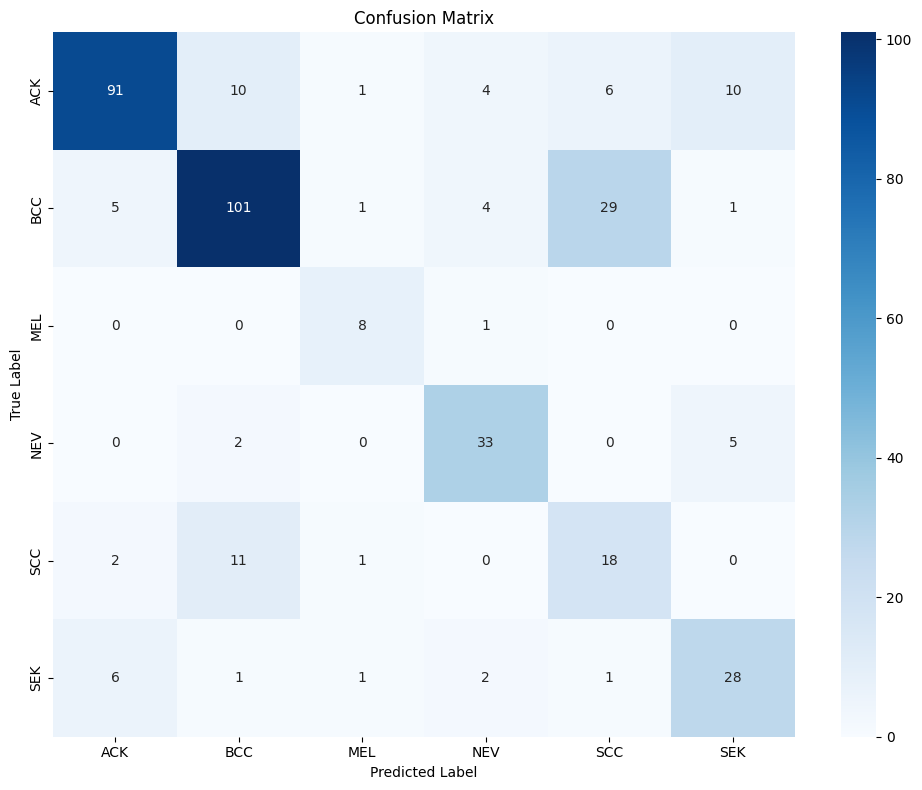

In [ ]:
val_preds = [int(p) for p in val_preds]
val_labels = [int(l) for l in val_labels]

# Classification report
report = classification_report(val_labels, val_preds, target_names=class_names)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# Get detailed metrics
prec, recall, f1, support = precision_recall_fscore_support(val_labels, val_preds, labels=list(range(len(class_names))))

# Save evaluation metrics to CSV
eval_df = pd.DataFrame({
    "Class": class_names,
    "Precision": prec,
    "Recall": recall,
    "F1-Score": f1,
    "Support": support
})

# Save to disk drive
csv_path = f"/content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/eval_metrics_{args.fusion}_{args.loss}_{args.input}_{args.mlp_depth}.csv"
eval_df.to_csv(csv_path, index=False)
print(f"Saved evaluation metrics to {csv_path}")


# Create W&B table
table = wandb.Table(columns=["Class", "Precision", "Recall", "F1-Score", "Support"])
for i, cls in enumerate(class_names):
    table.add_data(cls, round(prec[i], 4), round(recall[i], 4), round(f1[i], 4), support[i])

# Log it
wandb.log({"Per-Class Metrics": table})

Saved evaluation metrics to /content/drive/MyDrive/Final Year Project/Code/Ablation Study/Data/eval_metrics_attention_focal_multi_shallow.csv


In [ ]:
# W&B Final Logs
if args.use_wandb:
    wandb.log({
        "classification_report": wandb.Html(f"<pre>{report}</pre>"),
        "confusion_matrix": wandb.Image(fig)
    })
    wandb.save(args.save_path)

wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
